### Analyzing CIA Factbook Data Using SQLite and Python

#### In this project we'll be working with SQL in combination with Python. Specifically we'll use sqlite3. We will analyze the database file "factbook.db" which is the CIA World Factbook. We will write queries to look at the data and see if we can draw any interesting insights.

In [29]:
#import sql3, pandas and connect to the databse.
import sqlite3
import pandas as pd
conn = sqlite3.connect("factbook.db")

#activates the cursor
cursor = conn.cursor()

#the SQL query to look at the tables in the databse
q1 = "SELECT * FROM sqlite_master WHERE type='table';"

#execute the query and read it in pandas, this returns a table in pandas form
database_info = pd.read_sql_query(q1, conn)
database_info

,type,name,tbl_name,rootpage,sql
0,table,facts,facts,2,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY..."
1,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"


#### Let's begin exploring the data, we can use pd.read_sql_query to see what the first table looks like

In [30]:
q2 = "SELECT * FROM facts"

data = pd.read_sql_query(q2, conn)
data.head()

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,created_at,updated_at
0,1,af,Afghanistan,652230.0,652230.0,0.0,32564342.0,2.32,38.57,13.89,1.51,2015-11-01 13:19:49.461734,2015-11-01 13:19:49.461734
1,2,al,Albania,28748.0,27398.0,1350.0,3029278.0,0.30,12.92,6.58,3.30,2015-11-01 13:19:54.431082,2015-11-01 13:19:54.431082
2,3,ag,Algeria,2381741.0,2381741.0,0.0,39542166.0,1.84,23.67,4.31,0.92,2015-11-01 13:19:59.961286,2015-11-01 13:19:59.961286
3,4,an,Andorra,468.0,468.0,0.0,85580.0,0.12,8.13,6.96,0.00,2015-11-01 13:20:03.659945,2015-11-01 13:20:03.659945
4,5,ao,Angola,1246700.0,1246700.0,0.0,19625353.0,2.78,38.78,11.49,0.46,2015-11-01 13:20:08.625072,2015-11-01 13:20:08.625072


#### Let's see what the maximum and the minimum population is and then we'll identify the country name. If they are outliers, we should probably remove it from the table.

In [31]:
q3 = "SELECT MIN(population), MAX(population), MIN(population_growth), MAX(population_growth) FROM facts"
data = pd.read_sql_query(q3, conn)
data.head()

,MIN(population),MAX(population),MIN(population_growth),MAX(population_growth)
0,0,7256490011,0.0,4.02


In [32]:
q4 = '''
SELECT * FROM facts 
WHERE population == (SELECT MIN(population) from facts);
'''
data = pd.read_sql_query(q4, conn)
data.head()

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,created_at,updated_at
0,250,ay,Antarctica,None,280000,None,0,None,None,None,None,2015-11-01 13:38:44.885746,2015-11-01 13:38:44.885746


In [33]:
q5 = '''
SELECT * FROM facts 
WHERE population == (SELECT MAX(population) from facts);
'''
data = pd.read_sql_query(q5, conn)
data.head()

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,created_at,updated_at
0,261,xx,World,None,None,None,7256490011,1.08,18.6,7.8,None,2015-11-01 13:39:09.910721,2015-11-01 13:39:09.910721


#### It doesn't make much sense to include Antarctica and the entire world as a part of our data analysis, we should definitely exlude this from our analysis.

#### We can write a SQL query along with subqueries to exlude the min and max population from the data. 

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

q6 = '''
SELECT population, population_growth, birth_rate, death_rate
FROM facts
WHERE population != (SELECT MIN(population) from facts)
AND population != (SELECT MAX(population) from facts)
'''

data = pd.read_sql_query(q6, conn)
data.head()

,population,population_growth,birth_rate,death_rate
0,32564342,2.32,38.57,13.89
1,3029278,0.30,12.92,6.58
2,39542166,1.84,23.67,4.31
3,85580,0.12,8.13,6.96
4,19625353,2.78,38.78,11.49


#### Suppose we are the CIA and we are interested in the future prospects of the countries arround the world. We can plot histograms of the birth rate, death rate, and population growth of the countries.

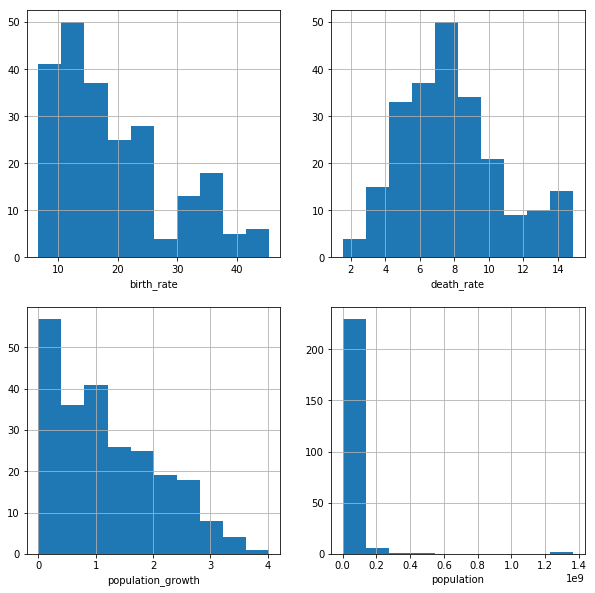

In [35]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

data["birth_rate"].hist(ax=ax1)
ax1.set_xlabel("birth_rate")
data["death_rate"].hist(ax=ax2)
ax2.set_xlabel("death_rate")
data["population_growth"].hist(ax=ax3)
ax3.set_xlabel("population_growth")
data["population"].hist(ax=ax4)
ax4.set_xlabel("population")

plt.show()

#### The birth_rate and population growth plot both show a right-skewed distribution, This makes sense as birth rate and population growth are directly related. The death_rate plot shows a normal distribution, almost a double peaked distribution. The population plot is a bit hard to read due to outliers.

#### Next we are interested to see what city has the highest population density

In [39]:

q7 = '''
SELECT name, CAST(population as float)/CAST(area as float) "density"
FROM facts
WHERE population != (SELECT MIN(population) from facts)
AND population != (SELECT MAX(population) from facts)
ORDER BY density DESC
'''

data = pd.read_sql_query(q7, conn)
data.head()

,name,density
0,Macau,21168.964286
1,Monaco,15267.500000
2,Singapore,8141.279770
3,Hong Kong,6445.041516
4,Gaza Strip,5191.819444


#### Looks like Macau has the highest population density in the world, not too surprising because Macau is a tourist heavy town with tons of casinos.

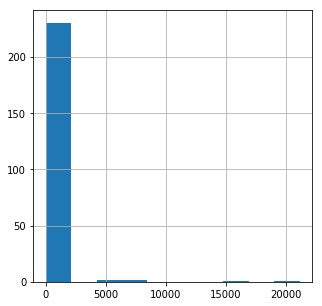

In [54]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)

data['density'].hist()

plt.show()

#### Again there are several outliers making the data hard to read, let's limit the histogram and increase the number of bins.

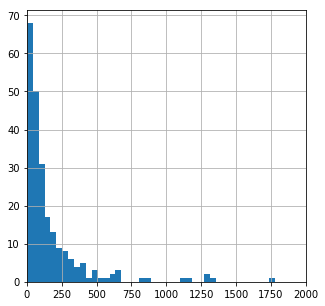

In [50]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

data['density'].hist(bins=500)
ax.set_xlim(0, 2000)
plt.show()

#### This table includes cities along with countries. The cities will obviously have way higher density than the countries. So plotting them both together in one histogram doesn't make much sense

#### This explains why the population histogram we did earlier showed a similar trend.